<a href="https://colab.research.google.com/github/Rudra-prasad-tarai/CreditRiskOptimisation/blob/main/Credit_Risk_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/Rudra-prasad-tarai/CreditRiskOptimisation
!pip install odfpy

Cloning into 'CreditRiskOptimisation'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 73 (delta 27), reused 26 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (73/73), 237.58 KiB | 4.85 MiB/s, done.
Resolving deltas: 100% (27/27), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for odfpy: filename=odfpy-1.4.1-py2.py3-none-any.whl size=160673 sha256=020392d81d1b42efbdd9a9ad020cb46017ad2fe6d7c4cfe6b2bf1d595a20a01d
  Stored in directory: /root/.cache/pip/wheels/d6/1d/c8/8c29be1d73ca42d15977c75193d9f39a98499413c2838ac54c
Successfully built odfpy


In [3]:
import pandas as pd
import numpy  as np
from tqdm import tqdm
import re
import datetime as dt

In [4]:
transition_matrix = pd.read_excel(
    '/content/CreditRiskOptimisation/data/CrisilTransitionMatrix.ods',
    engine='odf',
    skipfooter=2,          # Excludes last 2 rows
    index_col=0            # Uses 1st column as row labels (index)
)

In [5]:
bonds = pd.read_csv('/content/CreditRiskOptimisation/data/MW-Bonds-on-CM-18-Apr-2025.csv')


In [6]:
bonds.columns

Index(['SYMBOL \n', 'SERIES \n', 'BOND TYPE \n', 'COUPON RATE \n',
       'FACE VALUE \n', 'LTP \n', '%CHNG \n', 'VOLUME \n(Shares)',
       'VALUE \n (₹ Crores)', ' \n', 'CREDIT RATING \n', 'MATURITY DATE \n'],
      dtype='object')

In [7]:
bonds.isnull().sum()

,0
SYMBOL \n,0
SERIES \n,15
BOND TYPE \n,118
COUPON RATE \n,0
FACE VALUE \n,0
LTP \n,0
%CHNG \n,0
VOLUME \n(Shares),0
VALUE \n (₹ Crores),0
\n,398


In [8]:
bonds['VOLUME \n(Shares)'].unique()
bonds['FACE VALUE \n'].unique()

array(['1,000.00', '5,000.00', '-', '300.00', '400.00'], dtype=object)

In [9]:
# Deleting those bonds which does not have crisil rating
del bonds[bonds.columns[8]]
bonds.dropna(subset = ['CREDIT RATING \n'],inplace=True) #removed those whoo does not having crisil rating
print(bonds.columns)

Index(['SYMBOL \n', 'SERIES \n', 'BOND TYPE \n', 'COUPON RATE \n',
       'FACE VALUE \n', 'LTP \n', '%CHNG \n', 'VOLUME \n(Shares)', ' \n',
       'CREDIT RATING \n', 'MATURITY DATE \n'],
      dtype='object')


In [10]:
bonds['VOLUME \n(Shares)']

,VOLUME \n(Shares)
0,"5,678"
1,"4,469"
2,"4,008"
3,"2,515"
4,"2,760"
...,...
388,-
389,-
390,-
391,-


In [11]:


# Extract ONLY CRISIL ratings (case-insensitive, handles variations)
bonds['CREDIT RATING \n'] = bonds['CREDIT RATING \n'].str.extract(r'(CRISIL\s*[A-Za-z+-]+\s*[A-Za-z]*)', flags=re.IGNORECASE)

# Set non-CRISIL entries to NaN
bonds.loc[~bonds['CREDIT RATING \n' ].str.contains('CRISIL', na=False, case=False), 'CREDIT RATING'] = pd.NA

# Preprocessing
bonds['VOLUME \n(Shares)'] = bonds['VOLUME \n(Shares)'].str.replace('-', '0')
bonds['VOLUME \n(Shares)'] = bonds['VOLUME \n(Shares)'].str.replace(',', '').astype(int)  # or `float`
bonds['FACE VALUE \n'] = bonds['FACE VALUE \n'].str.replace('-', '0')
bonds['FACE VALUE \n'] = bonds['FACE VALUE \n'].str.replace(',', '').astype(float)
bonds['COUPON RATE \n'] = bonds['COUPON RATE \n'].str.replace('-', '0')
bonds['COUPON RATE \n'] = bonds['COUPON RATE \n'].str.replace(',', '').astype(float)   # or `float`



In [12]:
bonds.columns

Index(['SYMBOL \n', 'SERIES \n', 'BOND TYPE \n', 'COUPON RATE \n',
       'FACE VALUE \n', 'LTP \n', '%CHNG \n', 'VOLUME \n(Shares)', ' \n',
       'CREDIT RATING \n', 'MATURITY DATE \n', 'CREDIT RATING'],
      dtype='object')

In [13]:
bonds

,SYMBOL \n,SERIES \n,BOND TYPE \n,COUPON RATE \n,FACE VALUE \n,LTP \n,%CHNG \n,VOLUME \n(Shares),\n,CREDIT RATING \n,MATURITY DATE \n,CREDIT RATING
0,76NHAI31,NaN,Regular,7.60,1000.0,"1,100.81",-0.33,5678,NaN,CRISIL AAA STABLE,11-Jan-2031,NaN
1,728IRFC30,NG,Regular,7.28,1000.0,"1,115.00",0.81,4469,NaN,CRISIL AAA STABLE,21-Dec-2030,NaN
2,96IIFL28,N5,Regular,9.60,1000.0,952.00,-0.05,4008,NaN,CRISIL AA Stable,03-Nov-2028,NaN
3,734IRFC28,N4,Regular,7.34,1000.0,"1,078.00",-,2515,NaN,CRISIL AAA STABLE,19-Feb-2028,NaN
4,96IIFL28A,NF,Regular,9.60,1000.0,956.00,-0.02,2760,NaN,CRISIL AA Negative,24-Jun-2028,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
388,99SCL27V,N1,Regular,9.90,1000.0,948.78,-,0,NaN,CRISIL AA,27-Dec-2027,NaN
389,1025SCL34Z,N1,Regular,10.25,1000.0,990.00,-,0,NaN,CRISIL AA,27-Dec-2034,NaN
390,IHF261224A,N1,Regular,0.00,1000.0,-,-,0,NaN,CRISIL AA,26-Dec-2029,NaN
391,94SCL27U,N1,Regular,9.40,1000.0,-,-,0,NaN,CRISIL AA,27-Dec-2027,NaN


In [14]:
bonds.dropna(subset = ['CREDIT RATING \n'],inplace=True)

In [15]:
# from google.colab import files
# df = bonds['CREDIT RATING \n']
# df.to_csv('dat.csv')
# files.download('dat.csv')

In [16]:
bonds['CREDIT RATING \n'].unique()

array(['CRISIL AAA STABLE', 'CRISIL AA Stable', 'CRISIL AA Negative',
       'CRISIL AA-Positive ', 'CRISIL A', 'CRISIL AAA ',
       'CRISIL A Stable', 'CRISIL AA STABLE', 'CRISIL AA+ STABLE',
       'CRISIL AAA Stable', 'CRISIL AA', 'CRISIL A-', 'CRISIL AA-',
       'CRISIL A+'], dtype=object)

In [17]:
# Filter by credit rating
# bonds= bonds[bonds['CREDIT RATING \n'].isin(['AAA', 'AA+', 'AA', 'A+', 'A','AA ' ])]

# Filter by maturity (1–5 years from now)

today = dt.datetime.today()
cutoff = today + dt.timedelta(days=5*365)
bonds['MATURITY DATE \n'] = pd.to_datetime(bonds['MATURITY DATE \n'], errors='coerce')
bonds = bonds[(bonds['MATURITY DATE \n'] >= today) & (bonds['MATURITY DATE \n'] <= cutoff)]

# Filter by volume
bonds = bonds[bonds['VOLUME \n(Shares)'] > 5]

# You can manually tag 'Issuer Type' based on Symbol or ISIN
bonds_filtered = bonds[['SYMBOL \n', 'CREDIT RATING \n', 'COUPON RATE \n', 'LTP \n', 'MATURITY DATE \n', 'VOLUME \n(Shares)','FACE VALUE \n']]
bonds_filtered


,SYMBOL \n,CREDIT RATING \n,COUPON RATE \n,LTP \n,MATURITY DATE \n,VOLUME \n(Shares),FACE VALUE \n
2,96IIFL28,CRISIL AA Stable,9.60,952.00,2028-11-03,4008,1000.0
3,734IRFC28,CRISIL AAA STABLE,7.34,"1,078.00",2028-02-19,2515,1000.0
4,96IIFL28A,CRISIL AA Negative,9.60,956.00,2028-06-24,2760,1000.0
5,871REC28,CRISIL AAA STABLE,8.71,"1,123.36",2028-09-24,2163,1000.0
9,893NHB29,CRISIL AAA STABLE,8.93,"5,570.00",2029-03-24,210,5000.0
10,1003ISFL28,CRISIL AA-Positive,10.03,990.00,2028-12-21,1181,1000.0
11,875NHAI29,CRISIL AAA STABLE,8.75,"1,146.06",2029-02-05,930,1000.0
14,1065NFL27,CRISIL A,10.65,"1,002.00",2027-03-13,1001,1000.0
16,888NHB29,CRISIL AAA STABLE,8.88,"5,600.00",2029-01-13,174,5000.0
21,863IRFC29,CRISIL AAA STABLE,8.63,"1,116.00",2029-03-26,535,1000.0


In [18]:
# Example raw ratings from your dataset
raw_ratings = [                                            # observed from the filtererd data set
    'CRISIL AAA STABLE', 'CRISIL AA Stable', 'CRISIL AA Negative',
    'CRISIL AA-Positive ', 'CRISIL A', 'CRISIL AAA ',
    'CRISIL A Stable', 'CRISIL AA STABLE', 'CRISIL AA+ STABLE',
    'CRISIL AAA Stable', 'CRISIL AA', 'CRISIL A-', 'CRISIL AA-',
    'CRISIL A+'
]

# Define a mapping function
def normalize_rating(rating):
    rating = rating.strip().upper()
    if 'AAA' in rating:
        return 'AAA'
    elif 'AA' in rating:
        return 'AA'
    elif 'A' in rating:
        return 'A'
    elif 'BBB' in rating:
        return 'BBB'
    elif 'BB' in rating:
        return 'BB'
    elif 'B' in rating:
        return 'B'
    elif 'C' in rating:
        return 'C'
    elif 'D' in rating:
        return 'D'
    else:
        return 'Other'

# Gsec-yield (for discount Rate)
gsec_yield = 7

# Function to calculate MTM using G-Sec yield as discount rate
def calculate_mtm(row, discount_rate):
    face_value = row['FACE VALUE \n']
    coupon_rate = row['COUPON RATE \n'] / 100  # convert to decimal
    maturity_date = row['MATURITY DATE \n']

    # Calculate years to maturity
    years_to_maturity = (maturity_date - dt.datetime.now()).days / 365

    # Annual coupon payment
    annual_coupon = face_value * coupon_rate

    # Calculate MTM by discounting all future cash flows
    mtm = 0
    for year in range(1, int(years_to_maturity) + 1):
        mtm += annual_coupon / ((1 + discount_rate/100) ** year)  # discount_rate in decimal

    # Add discounted principal repayment
    mtm += face_value / ((1 + discount_rate/100) ** years_to_maturity)

    return mtm

# Add MTM column using G-Sec yield as discount rate
bonds_filtered['MTM_Gsec'] = bonds_filtered.apply(lambda row: calculate_mtm(row, gsec_yield), axis=1)



<ipython-input-18-e9d481e6d33c>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bonds_filtered['MTM_Gsec'] = bonds_filtered.apply(lambda row: calculate_mtm(row, gsec_yield), axis=1)


In [19]:
bonds_filtered['MAPPED RATING'] = bonds_filtered['CREDIT RATING \n'].map(normalize_rating)

<ipython-input-19-bc743143082e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bonds_filtered['MAPPED RATING'] = bonds_filtered['CREDIT RATING \n'].map(normalize_rating)


In [20]:
bonds_filtered

,SYMBOL \n,CREDIT RATING \n,COUPON RATE \n,LTP \n,MATURITY DATE \n,VOLUME \n(Shares),FACE VALUE \n,MTM_Gsec,MAPPED RATING
2,96IIFL28,CRISIL AA Stable,9.60,952.00,2028-11-03,4008,1000.0,1038.961061,AA
3,734IRFC28,CRISIL AAA STABLE,7.34,"1,078.00",2028-02-19,2515,1000.0,958.288946,AAA
4,96IIFL28A,CRISIL AA Negative,9.60,956.00,2028-06-24,2760,1000.0,1058.455822,AA
5,871REC28,CRISIL AAA STABLE,8.71,"1,123.36",2028-09-24,2163,1000.0,1021.461860,AAA
9,893NHB29,CRISIL AAA STABLE,8.93,"5,570.00",2029-03-24,210,5000.0,5005.372047,AAA
10,1003ISFL28,CRISIL AA-Positive,10.03,990.00,2028-12-21,1181,1000.0,1043.274051,AA
11,875NHAI29,CRISIL AAA STABLE,8.75,"1,146.06",2029-02-05,930,1000.0,1003.059675,AAA
14,1065NFL27,CRISIL A,10.65,"1,002.00",2027-03-13,1001,1000.0,979.308651,A
16,888NHB29,CRISIL AAA STABLE,8.88,"5,600.00",2029-01-13,174,5000.0,5048.878958,AAA
21,863IRFC29,CRISIL AAA STABLE,8.63,"1,116.00",2029-03-26,535,1000.0,992.917265,AAA


In [21]:
print(len(transition_matrix))
transition_matrix

7


,Issuer-months,AAA,AA,A,BBB,BB,B,C,D
Rating Category,,,,,,,,,
AAA,15796,0.9883,0.0116,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000
AA,40980,0.0226,0.9610,0.0154,0.0004,0.0001,0.0000,0.0000,0.0005
A,78111,0.0014,0.0339,0.9313,0.0313,0.0011,0.0002,0.0001,0.0007
BBB,211375,0.0000,0.0004,0.0320,0.9149,0.0461,0.0011,0.0003,0.0052
BB,308532,0.0000,0.0000,0.0001,0.0414,0.8896,0.0373,0.0015,0.0301
B,241508,0.0000,0.0000,0.0000,0.0003,0.0883,0.8235,0.0040,0.0839
C,5330,0.0000,0.0000,0.0000,0.0000,0.0072,0.1987,0.5521,0.2420


In [22]:
bonds_filtered['MTM_Gsec'].sum()

np.float64(61911.071362420604)

In [23]:
bonds_filtered

,SYMBOL \n,CREDIT RATING \n,COUPON RATE \n,LTP \n,MATURITY DATE \n,VOLUME \n(Shares),FACE VALUE \n,MTM_Gsec,MAPPED RATING
2,96IIFL28,CRISIL AA Stable,9.60,952.00,2028-11-03,4008,1000.0,1038.961061,AA
3,734IRFC28,CRISIL AAA STABLE,7.34,"1,078.00",2028-02-19,2515,1000.0,958.288946,AAA
4,96IIFL28A,CRISIL AA Negative,9.60,956.00,2028-06-24,2760,1000.0,1058.455822,AA
5,871REC28,CRISIL AAA STABLE,8.71,"1,123.36",2028-09-24,2163,1000.0,1021.461860,AAA
9,893NHB29,CRISIL AAA STABLE,8.93,"5,570.00",2029-03-24,210,5000.0,5005.372047,AAA
10,1003ISFL28,CRISIL AA-Positive,10.03,990.00,2028-12-21,1181,1000.0,1043.274051,AA
11,875NHAI29,CRISIL AAA STABLE,8.75,"1,146.06",2029-02-05,930,1000.0,1003.059675,AAA
14,1065NFL27,CRISIL A,10.65,"1,002.00",2027-03-13,1001,1000.0,979.308651,A
16,888NHB29,CRISIL AAA STABLE,8.88,"5,600.00",2029-01-13,174,5000.0,5048.878958,AAA
21,863IRFC29,CRISIL AAA STABLE,8.63,"1,116.00",2029-03-26,535,1000.0,992.917265,AAA


In [24]:
np.random.choice([0,5,6,8,9,4])

np.int64(5)

In [25]:
transition_matrix.columns

Index(['Issuer-months', 'AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'C', 'D'], dtype='object')

In [26]:
len(transition_matrix)

7

In [27]:
transition_matrix

,Issuer-months,AAA,AA,A,BBB,BB,B,C,D
Rating Category,,,,,,,,,
AAA,15796,0.9883,0.0116,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000
AA,40980,0.0226,0.9610,0.0154,0.0004,0.0001,0.0000,0.0000,0.0005
A,78111,0.0014,0.0339,0.9313,0.0313,0.0011,0.0002,0.0001,0.0007
BBB,211375,0.0000,0.0004,0.0320,0.9149,0.0461,0.0011,0.0003,0.0052
BB,308532,0.0000,0.0000,0.0001,0.0414,0.8896,0.0373,0.0015,0.0301
B,241508,0.0000,0.0000,0.0000,0.0003,0.0883,0.8235,0.0040,0.0839
C,5330,0.0000,0.0000,0.0000,0.0000,0.0072,0.1987,0.5521,0.2420


In [28]:
from tqdm import tqdm
# Example: Simplified transition matrix (rows = current rating, columns = next year's rating)


# Monte Carlo parameters
num_scenarios = 20_000  # Paper uses 20,000
recovery_rate = 0.30     # 30% recovery in default

# Simulate credit migrations for each bond
def simulate_credit_events(bond_ratings, transition_matrix, num_scenarios):
    scenarios = []
    d = {'AAA':0,'AA':1,'A':2,'BBB':3,'BB':4,'B':5,'C':6}
    # Configure tqdm with more options
    with tqdm(total=num_scenarios,
              desc="Credit Migration Simulation",
              unit="scenario",
              bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]") as pbar:

        for _ in range(num_scenarios):
            new_ratings = []
            for rating in bond_ratings:
                probs = transition_matrix.loc[rating].iloc[1:].tolist() # prob(---/rating)
                # print(f'\n {probs}')
                # print(f'size of transitioin_matrix is {len(transition_matrix.columns[1:][:])} and teh size of probs is {len(probs)}')
                new_rating = np.random.choice(transition_matrix.columns[1:][:], p=probs)
                new_ratings.append(new_rating)
            scenarios.append(new_ratings)

            pbar.update(1)  # Manually update progress bar

            # Optional: Add additional information to the progress bar
            if pbar.n % 1000 == 0:  # Update stats every 1000 scenarios
                pbar.set_postfix({
                    'current_rating': rating,
                    'scenarios': len(scenarios)
                })

    return scenarios# Example usage
bond_ratings = bonds_filtered['MAPPED RATING'].tolist()
credit_scenarios = simulate_credit_events(bond_ratings, transition_matrix, num_scenarios)

Credit Migration Simulation: 100%|██████████| 20000/20000 [03:47<00:00, 87.92scenario/s, current_rating=AA, scenarios=2e+4] 


In [29]:
zero_coupon_spreads = {
    'AAA':0.14,
    'AA+':0.44,
    'AA':0.76,
    'AA-':1.14,
    'A+':2.14,
    'A':2.39,
    'A-':2.64,
    'BBB+':3.14,
    'BBB':3.39,
    'BBB-':3.64,
    'BB+':3.89,    # values from here are randomly kept
    'BB':4.14,
    'BB-':4.39,
    'B+':4.64,
    'B':4.89,
    'B-':5.1,
    'C+':5.35,
    'C':5.5,
    'C-':5.65,
    'D':5.8
}

In [30]:
import numpy as np
from typing import Dict, List

# Credit Loss Calculation for portfolio given its

def calculate_credit_loss(
    future_credit_ratings: List[str],       # List of new ratings for each bond in scenario
    present_credit_ratings: List[str],     # Current ratings of bonds
    face_values: List[float],              # Face values of bonds
    coupons: List[float],                  # Annual coupon rates (e.g., 0.05 for 5%)
    maturities: List[float],               # Years to maturity
    zero_rate_gsec: float,                 # Risk-free zero rate (e.g., 0.07 for 7%)
    rating_spreads: Dict[str, float],      # Spreads over G-Sec by rating (e.g., {'AAA':0.01})
    valuation_date = None,                 # Valuation date (optional)
    recovery_rate: float = 0.30,           # Recovery rate in default
    time_horizon: float = 1.0              # 1-year forward valuation
) -> float:
    """
    Calculates portfolio loss for a single credit scenario by:
    1. Valuing bonds under current ratings (no migration)
    2. Valuing bonds under scenario ratings
    3. Computing loss as difference in portfolio values

    Returns:
        Loss amount (positive = loss, negative = gain)
    """
    if valuation_date is None:
        valuation_date = dt.date.today()
    # Validate inputs
    n_bonds = len(face_values)
    if not all(len(x) == n_bonds for x in [future_credit_ratings, present_credit_ratings,
                                          coupons, maturities]):
        raise ValueError("All input lists must have same length")

    # Calculate MTF (Mark-to-Future) under two scenarios
    mtf_no_migration = 0.0    # Portfolio value if no ratings change
    mtf_scenario = 0.0        # Portfolio value under credit scenario
    individual_loss = []      # Will Track Individual bond loss
    for i in range(n_bonds):
        # Bond parameters
        F = face_values[i]
        C = coupons[i] * F    # Annual coupon payment
        T = maturities[i]
        # print(f'{type(T)}    {type(valuation_date)}')
        remaining_T = (T.date() - valuation_date).days / 365.25

        # Skip bonds that mature before horizon (We are taking bonds higher than 5 years)
        if remaining_T <= 0:
            continue

        # 1. Value under NO MIGRATION (current rating)
        current_rating = present_credit_ratings[i]
        ytm_no_mig = zero_rate_gsec + rating_spreads[current_rating]
        bond_mtf_no_migration = _bond_mtf_value(C, F, remaining_T, ytm_no_mig)
        mtf_no_migration += bond_mtf_no_migration

        # 2. Value under SCENARIO (new rating)
        scenario_rating = future_credit_ratings[i]
        bond_mtf_migration = 0.0
        bond_mtf_no_migration = 0.0
        if scenario_rating == 'D':  # Default case
            bond_mtf_migration = F * recovery_rate
            mtf_scenario += bond_mtf_migration
        else:
            ytm_scenario = zero_rate_gsec + rating_spreads[scenario_rating]
            bond_mtf_migration = _bond_mtf_value(C, F, remaining_T, ytm_scenario)
            mtf_scenario += bond_mtf_migration
        individual_loss.append(bond_mtf_no_migration - bond_mtf_migration)

    # Loss = Value without migration - Value with migration
    return [individual_loss,mtf_no_migration - mtf_scenario]


def _bond_mtf_value(
    coupon: float,
    face_value: float,
    years_remaining: float,
    ytm: float
) -> float:
    """
    Helper: Calculates MTF value of a bond by discounting residual cash flows.
    Handles fractional years via continuous compounding.
    """
    value = 0.0
    for t in np.arange(1, int(years_remaining) + 1):
        value += coupon * np.exp(-ytm * t)

    # Add principal repayment
    value += face_value * np.exp(-ytm * years_remaining)
    return value

In [31]:
bonds_filtered['MAPPED RATING'].unique()

array(['AA', 'AAA', 'A'], dtype=object)

In [32]:
credit_scenarios_losses = []
zero_rate_gsec = 5.92
rating_spreads = zero_coupon_spreads
# Configure tqdm with more options
with tqdm(total=num_scenarios,
          desc="Credit Migration Loss Calculation",
          unit="scenario",
          bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]") as pbar:
    for i in range(len(credit_scenarios)):
        future_ratings = credit_scenarios[i]
        present_ratings = bonds_filtered['MAPPED RATING'].tolist()
        face_values = bonds_filtered['FACE VALUE \n'].tolist()
        coupons = bonds_filtered['COUPON RATE \n'].tolist()
        maturities = bonds_filtered['MATURITY DATE \n'].tolist()
        loss = calculate_credit_loss(future_ratings,present_ratings,face_values,coupons,maturities,zero_rate_gsec,rating_spreads)
        credit_scenarios_losses.append(loss)

        pbar.update(1)  # Manually update progress bar

        # Optional: Add additional information to the progress bar
        if pbar.n % 1000 == 0:  # Update stats every 1000 scenarios
            pbar.set_postfix({
                # 'current_rating': ,
                'scenarios': len(credit_scenarios_losses)
            })


Credit Migration Loss Calculation: 100%|██████████| 20000/20000 [00:41<00:00, 486.38scenario/s, scenarios=2e+4]


In [33]:
len(credit_scenarios_losses)

20000

In [34]:
credit_scenarios_losses[3]
print(len(credit_scenarios_losses[3][0]))

54


In [35]:
credit_scenarios_losses_ = []
for i in range(len(credit_scenarios_losses)):
    credit_scenarios_losses_.append(credit_scenarios_losses[i][1])

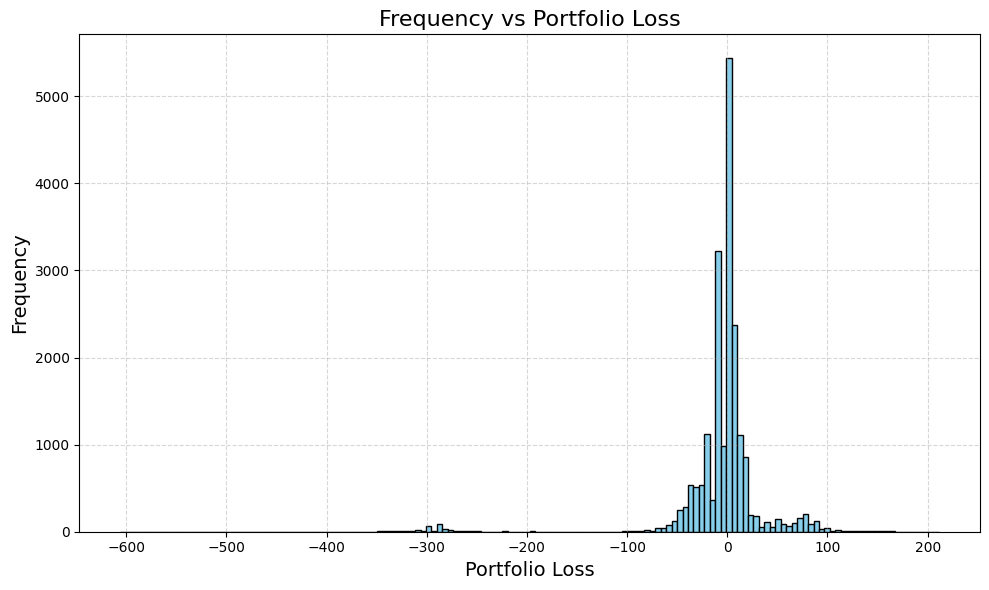

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Example: credit_scenarios_losses = np.random.normal(loc=50, scale=10, size=1000)
# (You can skip the line above if you already have your list)

plt.figure(figsize=(10, 6))
plt.hist(credit_scenarios_losses_, bins=150, color='skyblue', edgecolor='black')
plt.title('Frequency vs Portfolio Loss', fontsize=16)
plt.xlabel('Portfolio Loss', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [37]:
mean = np.mean(credit_scenarios_losses_)
std_deviation = np.std(credit_scenarios_losses_)

print(f"Mean: {mean}")
print(f"Standard Deviation: {std_deviation}")

Mean: -5.094146800996761
Standard Deviation: 46.642299568225205


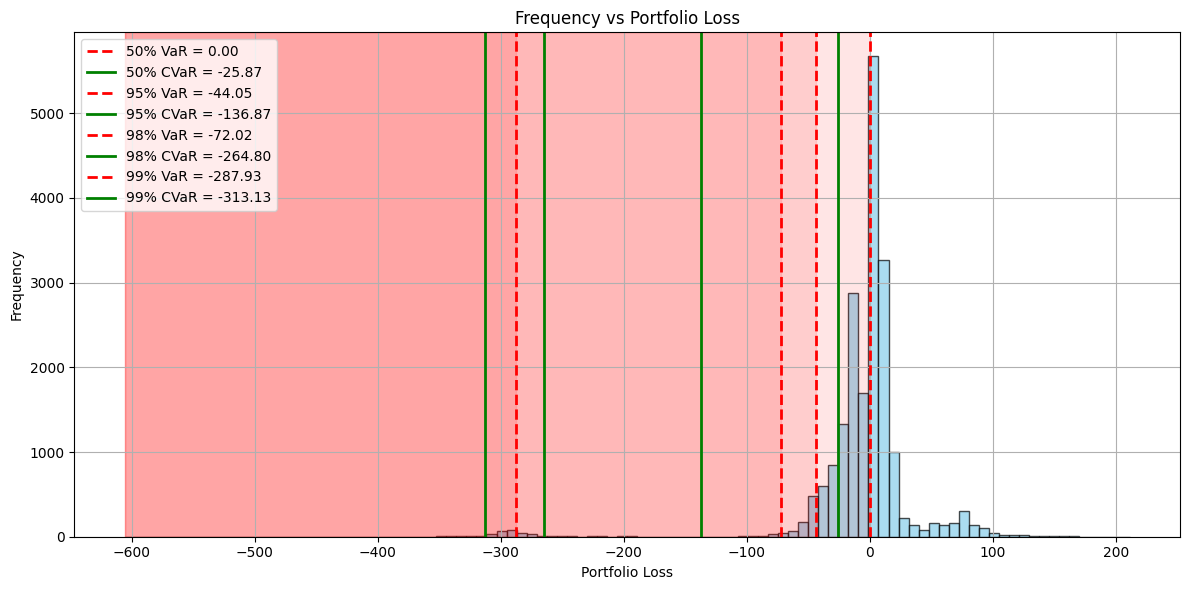

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_distribution_with_var_cvar(losses, percentiles=[50, 95, 98, 99]):
    sorted_losses = np.sort(losses)
    n = len(sorted_losses)

    plt.figure(figsize=(12, 6))
    counts, bins, patches = plt.hist(losses, bins=100, color='skyblue', edgecolor='black', alpha=0.7)

    for p in percentiles:
        alpha = 1 - (p / 100)
        index = int(np.floor(alpha * n))
        var = sorted_losses[index]
        cvar = sorted_losses[:index].mean() if index > 0 else var

        # Plot VaR (red dashed line)
        plt.axvline(var, color='red', linestyle='--', linewidth=2, label=f'{p}% VaR = {var:.2f}')

        # Plot CVaR (blue solid line)
        plt.axvline(cvar, color='green', linestyle='-', linewidth=2, label=f'{p}% CVaR = {cvar:.2f}')

        # Shade CVaR region
        plt.axvspan(min(losses), var, color='red', alpha=0.1)

    # Titles and labels
    plt.title("Frequency vs Portfolio Loss")
    plt.xlabel("Portfolio Loss")
    plt.ylabel("Frequency")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
losses = credit_scenarios_losses_
plot_loss_distribution_with_var_cvar(losses)

In [39]:
 loss_matrix_ = []
 for i in range(len(credit_scenarios_losses)):
    loss_matrix_.append(credit_scenarios_losses[i][0])
 loss_matrix =  np.array(loss_matrix_)

In [40]:
loss_matrix.shape

(20000, 54)

In [41]:
loss_matrix[0].shape

(54,)

<h1> Linear Programming and Optimisation

In [42]:
import cvxpy as cp
import numpy as np

def solve_cvar_lp(loss_matrix, q, l_bounds, u_bounds, r=None, R=None, beta=0.99):
    """
    Solves the CVaR optimization problem using the LP formulation.

    Parameters:
        loss_matrix (np.ndarray): Shape (J, n), losses of n assets in J scenarios
        q (np.ndarray): Size n, asset weights (or face values)
        l_bounds (np.ndarray): Lower bounds for x_i
        u_bounds (np.ndarray): Upper bounds for x_i
        r (np.ndarray): Asset returns (if return constraint needed)
        R (float): Required minimum return (optional)
        beta (float): Confidence level for CVaR

    Returns:
        dict: Optimal solution and CVaR
    """
    J, n = loss_matrix.shape
    v = 1 / ((1 - beta) * J)

    # Variables
    x = cp.Variable(n)
    alpha = cp.Variable()
    z = cp.Variable(J)

    # Objective
    objective = cp.Minimize(alpha + v * cp.sum(z))

    # Constraints
    constraints = []

    # (14) z_j ≥ (b_j ⋅ x) - α
    for j in range(J):
        constraints.append(z[j] >= loss_matrix[j] @ x - alpha)

    # (15) z_j ≥ 0
    constraints += [z >= 0]

    # (16) l_i ≤ x_i ≤ u_i
    constraints += [x >= l_bounds, x <= u_bounds]

    # (17) Budget constraint: ∑ q_i x_i = ∑ q_i
    constraints.append(cp.sum(cp.multiply(q, x)) == np.sum(q))

    # (18) Optional return constraint
    if r is not None and R is not None:
        constraints.append(cp.sum(cp.multiply(q * (r - R), x)) >= 0)

    # (19) Concentration constraint: x_i q_i ≤ 20% of ∑ q_i
    for i in range(n):
        constraints.append(x[i] * q[i] <= 0.20 * np.sum(q))

    # Solve
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return {
        "x": x.value,
        "alpha (VaR)": alpha.value,
        "CVaR": prob.value,
        "status": prob.status
    }



In [43]:
# Suppose you already have:
# loss_matrix: shape (J, n)
# q: face values (length n)
# l_bounds = np.zeros(n)
# u_bounds = np.ones(n)
n = loss_matrix.shape[1]
result = solve_cvar_lp(
    loss_matrix=loss_matrix,
    q=bonds_filtered['FACE VALUE \n'].tolist(),
    l_bounds=np.zeros(n),
    u_bounds=np.ones(n),
    # r=your_returns,       # Optional
    R=0.01,               # Target return if needed
    beta=0.99
)
print("Optimal weights:", result["x"])
print("VaR (alpha):", result["alpha (VaR)"])
print("CVaR:", result["CVaR"])


Optimal weights: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
VaR (alpha): -1903.0470900733094
CVaR: -1881.8631383688205


In [44]:
n

54

<h3> xi is non negative i.e it cannot be shortsell, also it can be longed for twice as present

In [45]:
result_no_shorting = solve_cvar_lp(
    loss_matrix=loss_matrix,
    q=bonds_filtered['FACE VALUE \n'].tolist(),
    l_bounds=np.zeros(n),
    u_bounds=np.full(n,2),
    # r=your_returns,       # Optional
    R=0.01,               # Target return if needed
    beta=0.99
)
print("Optimal weights:", result_no_shorting["x"])
print("VaR (alpha):", result_no_shorting["alpha (VaR)"])
print("CVaR:", result_no_shorting["CVaR"])

Optimal weights: [ 1.27321991e-11  2.00000000e+00  1.33475751e-11  2.00000000e+00
  2.00000000e+00  3.47941443e-11  2.00000000e+00 -1.85461622e-13
  2.00000000e+00  2.00000000e+00  2.00000000e+00 -8.33240690e-14
 -2.04691052e-13  5.25704737e-10  2.00000000e+00  4.82642270e-12
  2.00000000e+00  5.29519788e-12  2.04838799e-12  2.15107650e-12
  1.74791711e+00  3.86349188e-12  2.42872710e-12  1.73625615e-12
  3.13827837e-12  3.70124721e-12  2.00000000e+00  2.00000000e+00
  1.66468306e+00  2.00000000e+00  4.38527534e-11  7.18859639e-12
 -1.60933904e-13  8.28301032e-12  2.00000000e+00  2.00000000e+00
  7.67547198e-12  1.35738938e-02 -2.74979781e-15  2.00000000e+00
  2.00000000e+00  3.41025360e-12  2.99681599e-12  2.00000000e+00
  2.00000000e+00  1.94360035e-12  2.00000000e+00  2.00000000e+00
  2.00000000e+00 -3.12096434e-13 -3.25506432e-13  5.73825933e-01
  3.50652439e-12  4.51411150e-12]
VaR (alpha): -3218.5809333389802
CVaR: -3177.3089338394466


In [46]:
result = solve_cvar_lp(
    loss_matrix=loss_matrix,
    q=bonds_filtered['FACE VALUE \n'].tolist(),
    l_bounds=np.full(n,-2),
    u_bounds=np.full(n,2),
    # r=your_returns,       # Optional
    R=0.01,               # Target return if needed
    beta=0.99
)
print("Optimal weights:", result["x"])
print("VaR (alpha):", result["alpha (VaR)"])
print("CVaR:", result["CVaR"])

Optimal weights: [ 1.7860123   2.          1.24565941  2.          2.          1.74463182
  2.         -0.6171656   2.          2.          2.         -2.
 -0.61715648  2.          2.         -0.12075463  2.         -0.15714494
 -0.32368367 -0.05292481  2.         -0.32018176 -0.61856689 -0.63354457
 -0.63575577 -0.61235739  2.          2.          2.          2.
  2.         -0.2128166  -0.59486324  1.36192621  2.          2.
 -0.01802564  2.         -2.          2.          2.         -0.52445389
 -0.2232453   2.          2.         -0.51393562  2.          2.
  2.         -2.         -0.67375372  2.         -0.10509311 -0.56280611]
VaR (alpha): -3304.125166567102
CVaR: -3250.450268589333


In [47]:
print("Optimal weights:", result["x"])
print("VaR (alpha):", result["alpha (VaR)"])
print("CVaR:", result["CVaR"])

Optimal weights: [ 1.7860123   2.          1.24565941  2.          2.          1.74463182
  2.         -0.6171656   2.          2.          2.         -2.
 -0.61715648  2.          2.         -0.12075463  2.         -0.15714494
 -0.32368367 -0.05292481  2.         -0.32018176 -0.61856689 -0.63354457
 -0.63575577 -0.61235739  2.          2.          2.          2.
  2.         -0.2128166  -0.59486324  1.36192621  2.          2.
 -0.01802564  2.         -2.          2.          2.         -0.52445389
 -0.2232453   2.          2.         -0.51393562  2.          2.
  2.         -2.         -0.67375372  2.         -0.10509311 -0.56280611]
VaR (alpha): -3304.125166567102
CVaR: -3250.450268589333
